# <!-- TITLE --> __``` OBJECT DETECTION ```__
#### <!-- AUTHOR --> - Author : __Dr. Amiehe-Essomba__ (c) 2023
<img width="600px" height="400px" src="images/img_pred.jpg"></img>

## __```This notebook is only used for image predictions```__


> For video predictions please go [here](https://vision-api.streamlit.app/)

In [24]:
import tensorflow as tf
from yolo.predictions import prediction
from yolo.utils.tools import read_classes, read_anchors
from yolo.utils.tools import preprocess_image
from model_body.url import url_img_read
import logging
import pandas as pd 
from skimage.transform import resize
import seaborn as sns
from yolo.utils.tools import get_colors_for_classes
import random
import matplotlib.colors as mcolors
from random import sample
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
np.random.seed(3)

#### __```Image Path here```__

In [2]:
path = "https://arc-anglerfish-eu-central-1-prod-leparisien.s3.amazonaws.com/public/LG3NDHVJZYDGUHIJI3AG2K6JDU.jpg"

#### __```Image Process Here```__

In [3]:
online_image = True
yolo_shape   = (608, 608)

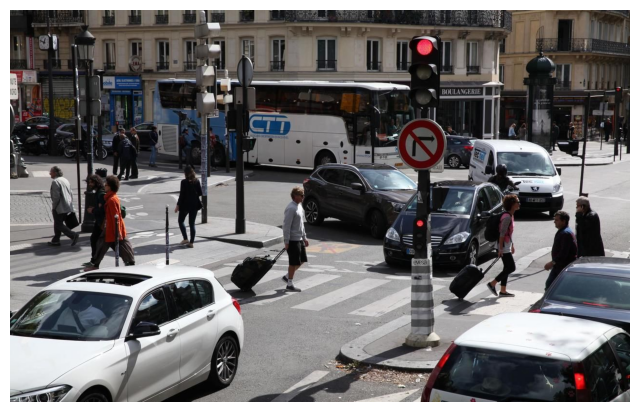

In [4]:
if online_image:
    image = url_img_read(path, show=True)
    image, image_data, shape = preprocess_image(img_path=image, model_image_size = yolo_shape, done=True)
else:
    image, image_data, shape = preprocess_image(img_path=path, model_image_size = yolo_shape, done=False)


#### __```Loading model```__

In [5]:
tf.get_logger().setLevel(logging.ERROR)

In [6]:
yolo_model = tf.keras.models.load_model('./yolo_model/')

#### __```Reading all classes and anchors```__

In [7]:
Class_names         = read_classes()
anchors             = read_anchors()

#### __```Hyper Parameters. You can change them```__

In [15]:
classes         = []
max_boxes       = 20
class_names     = []
score_threshold = 0.2
iou_threshold   = 0.2
response        = False
file_type       = 'image'
df              = {'label' : [], 'score':[], 'top':[], "left":[], "bottom":[], 'right':[]}

#### __```Do not change this part of notebook.```__

In [16]:
if class_names: pass 
else: class_names = Class_names.copy()

kwargs = {
    "class_names"       : Class_names, 
    'image_file'        : [(image, image_data)],
    "Class_names"       : Class_names,
    "max_boxes"         : max_boxes,
    "score_threshold"   : score_threshold,
    "iou_threshold"     : iou_threshold,
    "anchors"           : anchors
}

#### __```Set color boxes. Do not change anything here```__

In [17]:
class_names = kwargs['Class_names']
colors_     = get_colors_for_classes(len(class_names) + 10)

def f():
    s = random.sample(range(50), 1)
    return s[0] 

def g():
    num = random.sample(range(len(colors_)), len(class_names))
    return num 

colors      = {class_names[j] : colors_[i] if colors_[i] != (255, 255, 0) else colors_[j-1] for j, i in enumerate(g())}

### Gradient weight Class Activation Mapping

Note that is the argument grad_cam is True the len(image_predicted) == 3
* image_predicted[0] is the predicted image
* image_predicted[1] is the grad cam 
* image_predicted[2] is the guided grad cam 

else image_predicted is a simple numpy array 

In [18]:
# note
grad_cam = True

#### __```Image prediction. Do not change anything here```__

In [19]:


image_predicted = prediction(
            yolo_model      = yolo_model, 
            use_classes     = kwargs['class_names'],
            image_file      = kwargs['image_file'], 
            anchors         = kwargs['anchors'], 
            class_names     = kwargs['Class_names'], 
            img_size        = yolo_shape,
            max_boxes       = kwargs['max_boxes'], 
            score_threshold = kwargs['score_threshold'], 
            iou_threshold   = kwargs['iou_threshold'], 
            data_dict       = df,
            shape           = shape, 
            file_type       = 'image', 
            with_score      = response,
            colors          = colors,
            grad_cam        = grad_cam
            )

#### __```Resizing images```__

In [20]:
if grad_cam is False:
    imgs = [ resize(image_data.reshape(yolo_shape+(3,)), output_shape=shape), image_predicted]
    img_classes = ['True Label', 'Predicted Label']
    n = 2
else:
    imgs = [ resize(image_data.reshape(yolo_shape+(3,)), output_shape=shape), image_predicted[0], image_predicted[1], image_predicted[2]]
    img_classes = ['True Label', 'Predicted Label', "grad cam", "guided gram cam"]
    n = 4

#### Results 

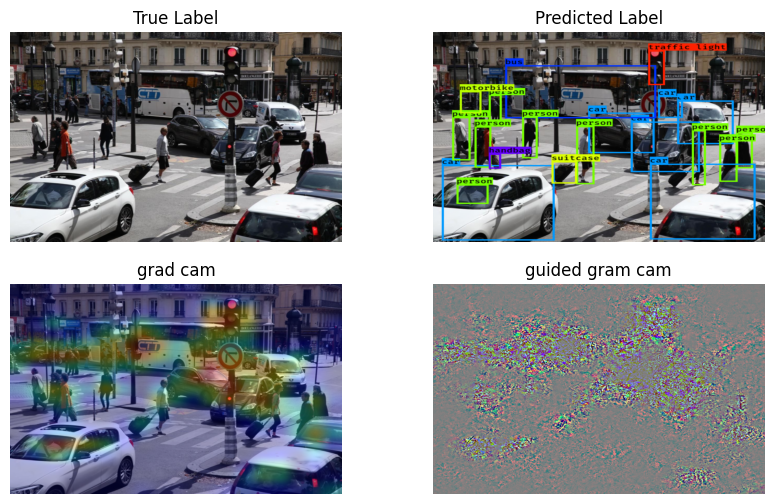

In [21]:
if grad_cam :
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    index = -1
    for i in range(2):
        for j in range(2):
            index += 1
            ax[i, j].axis('off')
            ax[i, j].imshow(imgs[index])
            ax[i, j].set_title(img_classes[index])
else:
    fig, ax = plt.subplots(1, n, figsize=(8 * n, 8))
    for i in range(n):
        ax[i].axis('off')
        ax[i].imshow(imgs[i])
        ax[i].set_title(img_classes[i])
plt.show()

#### __```Using the dictionary generated by the prediction to see all classes include in the predicted image```__
----

In [22]:
data_frame = pd.DataFrame(df)
data_frame.rename(columns={'label':'classes'}, inplace=True)
data_frame['label'] = [1 for i in range(len(data_frame.iloc[:, 0]))]


#### __```Classes countplot```__

In [43]:
# colors
python_colors   = np.array( list( mcolors.CSS4_COLORS.keys() ) )
length          = len(set(df['label']))
indexes         = sample(range(python_colors.shape[0]), k=length)
unique_color    = list( python_colors[indexes] )
print(f"unique classes : {length}")


unique classes : 7


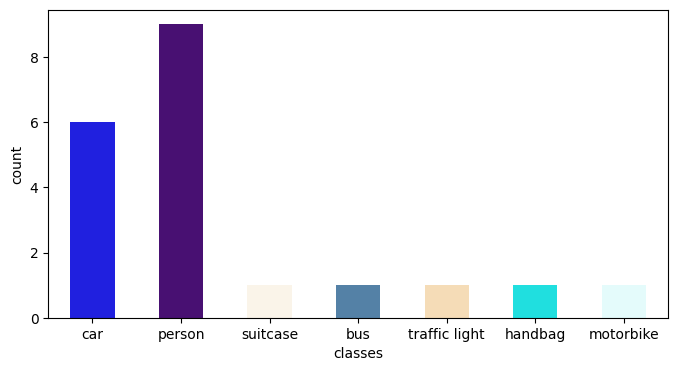

In [44]:
plt.figure(figsize=(8,4))
sns.countplot(data=data_frame, x='classes', palette=unique_color, hue='classes', width=0.5)
plt.show()

#### __```Data Frame created wih :```__

* classes
* scores
* the score of prediction
* bonding boxes 
* the encoded classses

In [17]:
display(data_frame.tail())

,classes,score,top,left,bottom,right,label
3,person,0.60,269,92,330,131,1
4,bus,0.51,150,400,460,530,1
5,person,0.47,295,569,487,608,1
6,person,0.35,328,1,412,25,1
7,person,0.33,308,463,341,482,1


<img width="180px" height="200px" src="https://i.pinimg.com/originals/18/e1/11/18e1110635dc82318910603571fe4e5a.jpg"></img>